In [2]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
%load_ext autoreload
%autoreload 2

In [3]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [4]:
bad = []
for isub in range(exp.nsub):
    try:
        beh = exp.load_behavior(isub)
    except:
        bad.append(isub)

In [5]:
exp.xdata_files = exp.xdata_files[2:]
exp.ydata_files = exp.ydata_files[2:]
exp.behavior_files = exp.behavior_files[2:]
exp.artifact_idx_files = exp.artifact_idx_files[2:]
exp.nsub = len(exp.xdata_files)

In [91]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 100
group_dict = OrderedDict([('1 Motions',[21]),('2 Motions',[22])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [105]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    coh_idx = beh['Coherences'].apply(lambda row: int(row[1]))
    ss1_idx = beh.SetSize==1
    feat_idx = np.array(beh['BlockFeature'],dtype=bool)

    xdata, ydata = xdata[ss1_idx&feat_idx], coh_idx[ss1_idx&feat_idx].values

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 
interp_motion.save_results()

0
1
2
3
4
5
6


Significant timepoints: [  16  352  376  400  424  448  472  496  520  616  640  736  784  808
 1312]
Mean delay accuracy: 0.5728392857142858
Mean delay S.D.: 0.06026969309372867


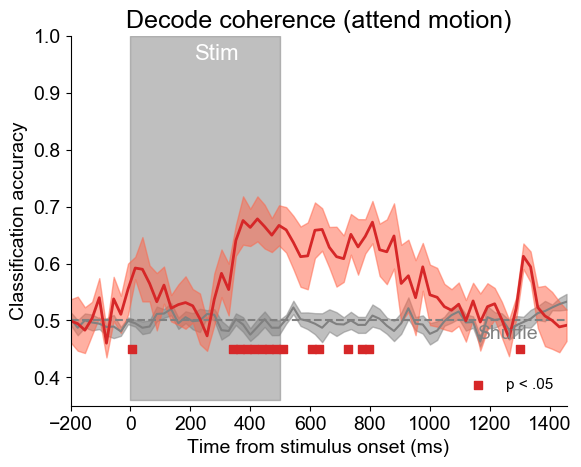

In [106]:
import matplotlib.pyplot as plt
interp_motion.plot_acc(significance_testing=True,savefig=False,
                ylim=[0.35,1],
                title='Decode coherence (attend motion)',stim_time=[0,500])
plt.show()

# attend color 

In [107]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    coh_idx = beh['Coherences'].apply(lambda row: int(row[1]))
    ss1_idx = beh.SetSize==1
    # grab attend color trials
    feat_idx = ~np.array(beh['BlockFeature'],dtype=bool)

    xdata, ydata = xdata[ss1_idx&feat_idx], coh_idx[ss1_idx&feat_idx].values

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_color = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_color') 
interp_color.save_results()

0
1
2
3
4
5
6


Significant timepoints: []


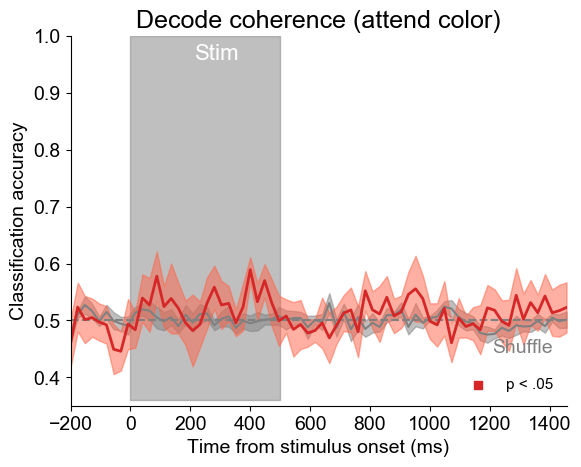

Mean delay accuracy: 0.5090178571428572
Mean delay S.D.: 0.022936629369563755


In [12]:
import matplotlib.pyplot as plt
interp_color.plot_acc(significance_testing=True,savefig=False,
                ylim=[0.35,1],chance_text_xy=(.85,.18),
                title='Decode coherence (attend color)',stim_time=[0,500])
plt.show()

# compare

In [6]:
interp_color = eeg_decoder.Interpreter()
interp_color.load_results('coh_attend_color')
interp_motion = eeg_decoder.Interpreter()
interp_motion.load_results('coh_attend_motion')

In [14]:
# Combine acc matrices for plotting
interp_color.acc = np.concatenate([interp_color.acc[:,np.newaxis],interp_motion.acc[:,np.newaxis]],1)
interp_color.acc_shuff = np.concatenate([interp_color.acc_shuff[:,np.newaxis],interp_motion.acc_shuff[:,np.newaxis]],1)

d:\Duel_Feature_Change_Detection\eggtoss\analysis\../..\eeg_decoder.py:1273: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


Attend Color mean delay accuracy: 0.5090178571428572
Attend Color mean delay S.D.: 0.022936629369563755
Attend Motion mean delay accuracy: 0.5728392857142858
Attend Motion mean delay S.D.: 0.06026969309372867
mean delay accuracy: 0.5728392857142858
mean delay S.D.: 0.06026969309372867


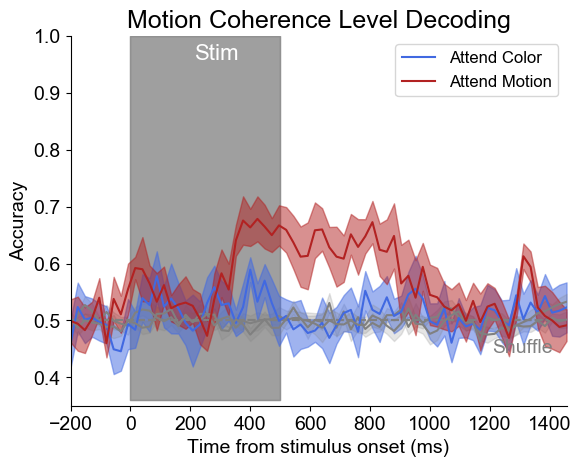

In [15]:
interp_color.plot_acc_compare_subset(
    subset_list=['Attend Color','Attend Motion'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_xy=(.85,.18),
    stim_time=[0,500],
    significance_testing=True,
    subtitle='coherence_compare',
    title='Motion Coherence Level Decoding',
    savefig=False)